In [2]:
import math
import tabulate
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

sns.set(style="ticks")
sns.set_context("talk")

In [3]:
df = pd.read_csv("data.csv")
df["sex"] = df["sex"].replace(1, "Male").replace(2, "Female")
df.rename(columns={"altersjahr": "age"}, inplace=True)
df["outcome"] = df["Anzahl Todesfälle"].replace(1, "Death").replace(0, "None or Cured")

# Data Preparation

All the data has been downloaded from the official [BAG Website](https://www.bag.admin.ch/bag/de/home/krankheiten/ausbrueche-epidemien-pandemien/aktuelle-ausbrueche-epidemien/novel-cov/situation-schweiz-und-international.html).

Let's generate a quick overview of the data. We're currently mainly interested in numberical data. It looks like they provide the same data in multiple languages (probably due to the application being i18n), we're lucky there isn't much data.

In [4]:
df.describe()

,Todesfälle_excluded,Anzahl Todesfälle,Nombre de cas confirmés en laboratoire,Nombre de cas décédés,Cas confirmés en laboratoire excluded,Cas décédés excluded,F1,Laborbestätigte Fälle excluded,Number of Records,Tooltip_incidence_fr,age,Anzahl laborbestätigte Fälle,pttod
count,18656.000000,18656.000000,18656.0,18656.000000,18656.0,18656.000000,18656.000000,18656.0,18656.0,0.0,18656.000000,18656.0,482.0
mean,0.025836,0.025836,1.0,0.025836,1.0,0.025836,11106.954545,1.0,1.0,NaN,53.075793,1.0,1.0
std,0.158651,0.158651,0.0,0.158651,0.0,0.158651,5597.636816,0.0,0.0,NaN,19.719729,0.0,0.0
min,0.000000,0.000000,1.0,0.000000,1.0,0.000000,1093.000000,1.0,1.0,NaN,0.000000,1.0,1.0
25%,0.000000,0.000000,1.0,0.000000,1.0,0.000000,6339.750000,1.0,1.0,NaN,38.000000,1.0,1.0
50%,0.000000,0.000000,1.0,0.000000,1.0,0.000000,11145.500000,1.0,1.0,NaN,53.000000,1.0,1.0
75%,0.000000,0.000000,1.0,0.000000,1.0,0.000000,15945.250000,1.0,1.0,NaN,67.000000,1.0,1.0
max,1.000000,1.000000,1.0,1.000000,1.0,1.000000,22645.000000,1.0,1.0,NaN,108.000000,1.0,1.0


# Demographics
Let's look at the demographics first (sex and age) and generate a few useful plots. First, let's show the ranges of people tested positive by sex.

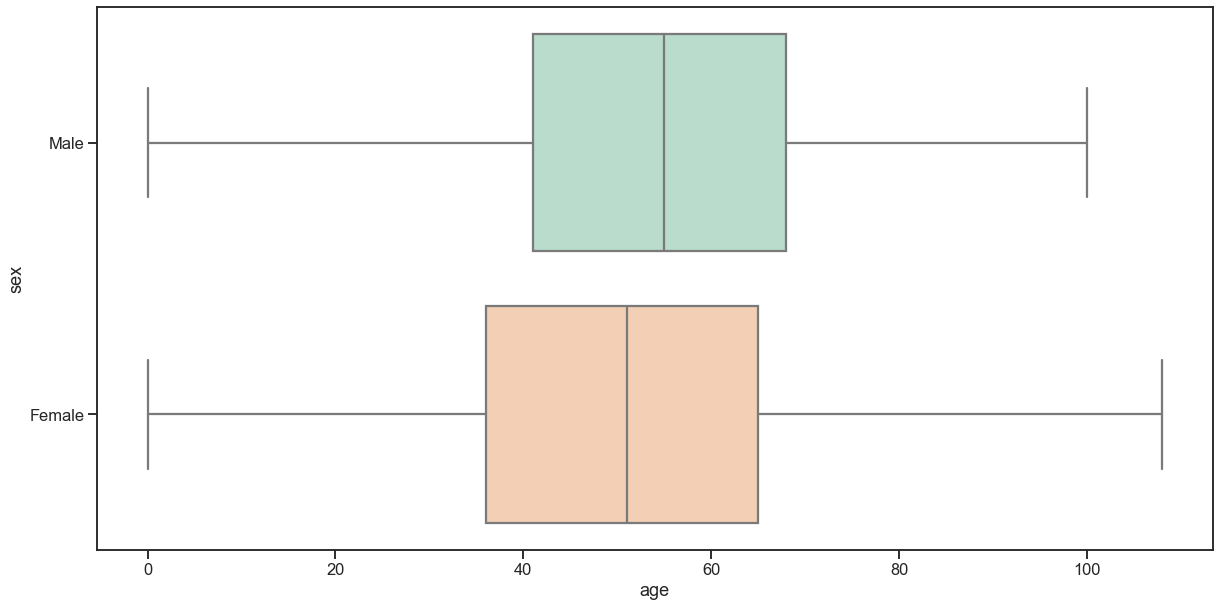

In [5]:
plt.figure(figsize=(20, 10))
sns.boxplot(x="age", y="sex", data=df,
            whis="range", palette="Pastel2")

In the plot above, we see boxplots respresenting the age distribution of positively tested males and females. They look quite similar. The median age is shown as the vertical line inside the coloured box. The upper and lower limits of the boxes are the lower and upper quartile, $Q_1$ and $Q_3$, respectively. The whiskers present the range which goes from 0 years up to agove 100 years, however, most of the cases are represented by the coloured boxes. Let's plot some histograms to have a closer look.

Text(0.5, 1.0, 'Age Distribution')

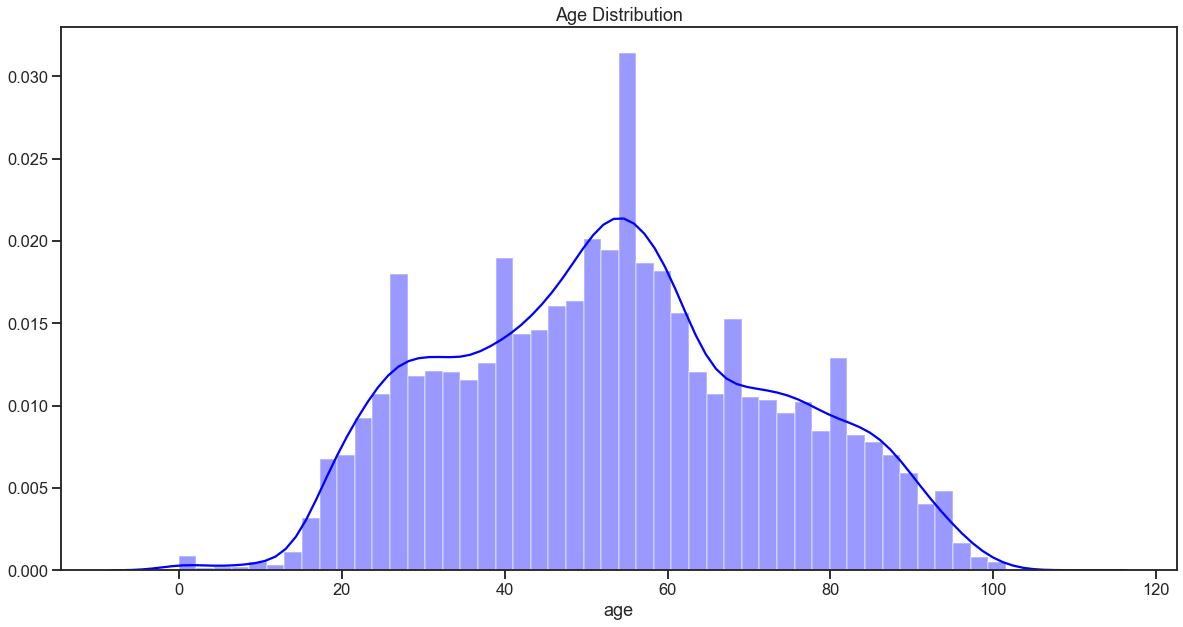

In [6]:
plt.figure(figsize=(20, 10))
sns.set_palette("Dark2")
sns.distplot(df["age"], color="Blue").set_title('Age Distribution')

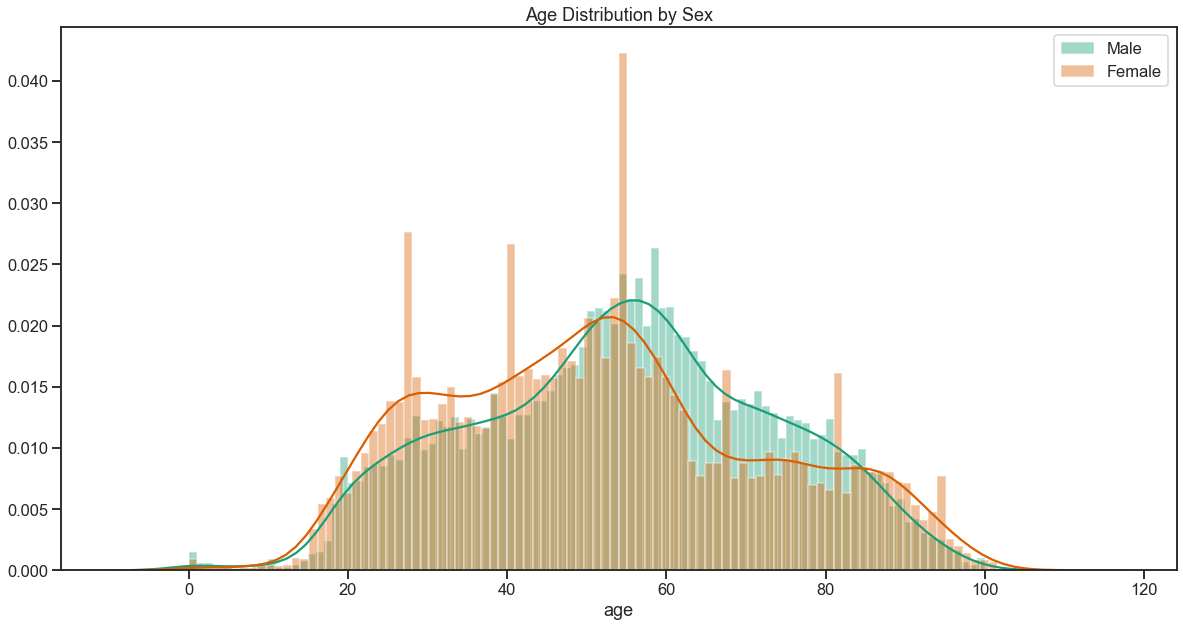

In [7]:
plt.figure(figsize=(20, 10))
sns.set_palette("Dark2")
sns.distplot(df[df["sex"]=="Male"]["age"], label="Male", bins=100)
sns.distplot(df[df["sex"]=="Female"]["age"], label="Female", bins=100)
plt.xlabel("age")
plt.title("Age Distribution by Sex")
plt.legend()

# Cantons
Now let's look how things are in different cantons.

Text(0.5, 1.0, 'Age by Canton')

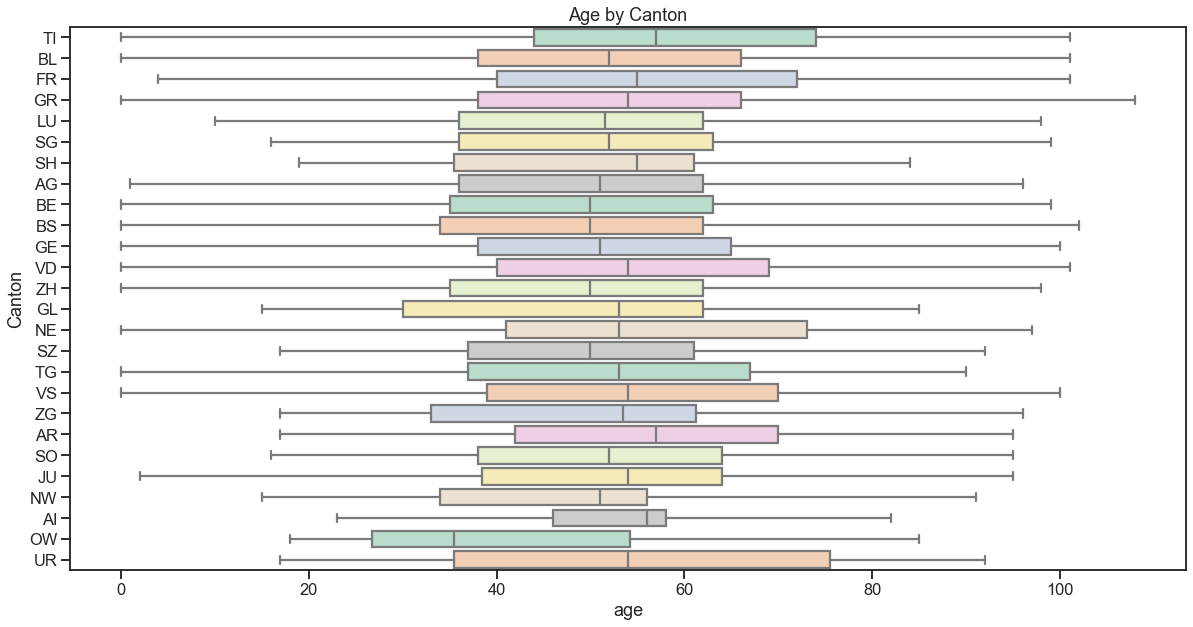

In [8]:
sns.set_palette("Dark2")
plt.figure(figsize=(20, 10))
sns.boxplot(x="age", y="Canton", data=df,
            whis="range", palette="Pastel2")
plt.title("Age by Canton")

Obwalden looks quite interesting (the median age is below 40). Let's have a quick look at how the means correlate.

Let's do some quick independent t-tests to see whether there are any significant differences between two cantons in terms of the average age.

Text(0.5, 1, 'Independent t-Tests on Age between Cantons')

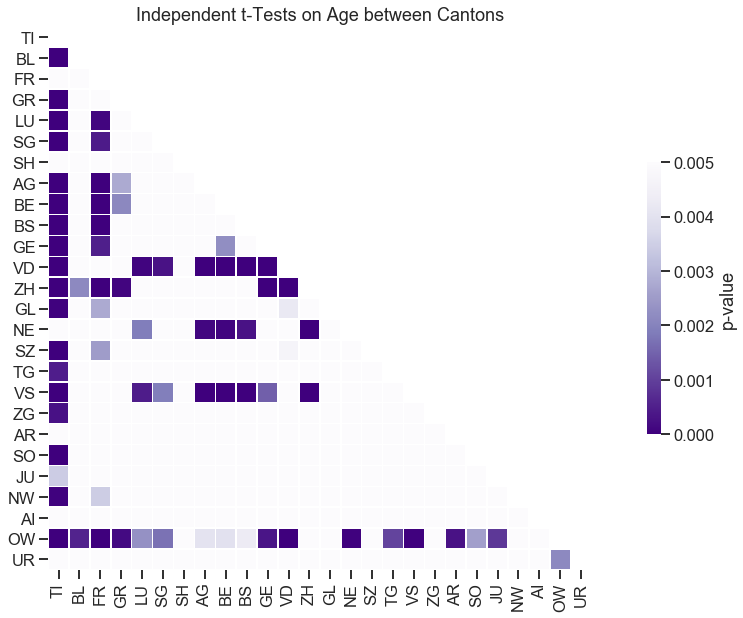

In [9]:
plt.figure(figsize=(20, 10))
cantons = df["Canton"].unique()
canton_age = {canton: df[df["Canton"] == canton]["age"].to_numpy() for canton in cantons}

t_stats = []

for i, a in enumerate(cantons):
    t_stats.append([])
    for j, b in enumerate(cantons):
        t = stats.ttest_ind(canton_age[a], canton_age[b])
        t_stats[i].append(math.sqrt(t.pvalue * t.pvalue))
#         print(a, b, t.pvalue)

g = sns.heatmap(t_stats, xticklabels=cantons, yticklabels=cantons, mask=np.triu(t_stats), vmax=0.005,
                square=True, linewidths=.5, cbar_kws={"shrink": .5, "label": "p-value"}, cmap="Purples_r")

plt.title("Independent t-Tests on Age between Cantons")
# stats.f_oneway(*cols)

Interesting stuff. It looks like the medium age of patients from Ticino and Obwalden are significantly different from many other cantons. Let's have a closer look.

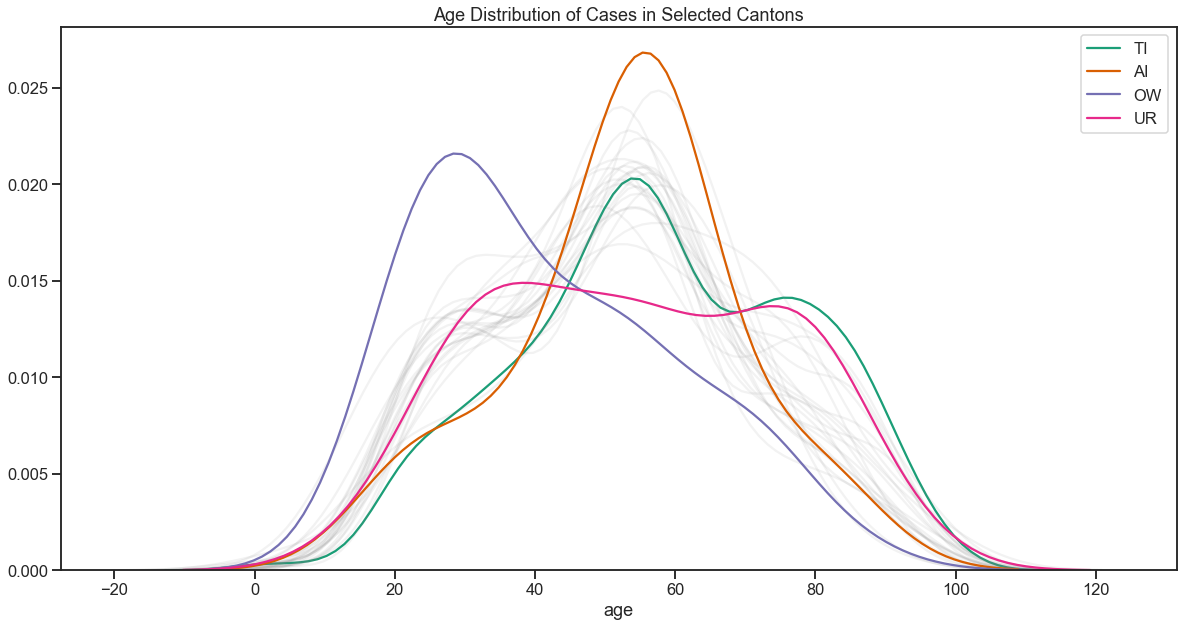

In [10]:
plt.figure(figsize=(20, 10))
sns.set_palette("Dark2")
for canton in df["Canton"].unique():
    if canton in ["OW", "TI", "AI", "UR"]:
        sns.distplot(df[df["Canton"]==canton]["age"], label=canton, hist=False)
    else:
        sns.distplot(df[df["Canton"]==canton]["age"], hist=False, color="gray", kde_kws={"alpha": 0.1})

plt.title("Age Distribution of Cases in Selected Cantons")
plt.legend()

Interestingly, the defining feature of Obwalden, when looking at the age-distribution, is a peak at around 25-30 years. This peak is can also be found in most other distributions, however, to a lesser extent. For Ticino, though, such a peak is missing. Another interesting canton is Appenzell Inerrhoden, which expresses a very narrow distribution around just below 60. Uri looks really interesting as well, as it is the only canton without a clear peak. Could sex play a role in the differences expressed by the data from these cantons? According to the plot below, probably not.

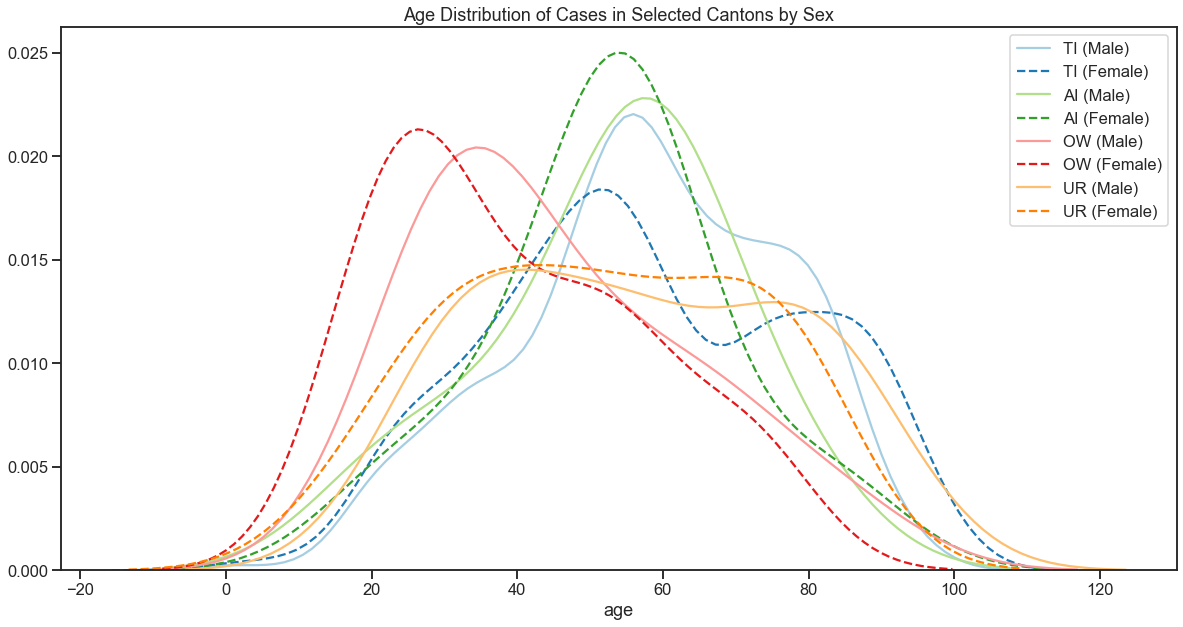

In [11]:
plt.figure(figsize=(20, 10))
sns.set_palette("Paired")
for canton in df["Canton"].unique():
    if canton in ["OW", "TI", "AI", "UR"]:
        sns.distplot(df[(df["Canton"]==canton) & (df["sex"] == "Male")]["age"], label=canton + " (Male)", hist=False)
        sns.distplot(df[(df["Canton"]==canton) & (df["sex"] == "Female")]["age"], label=canton + " (Female)", hist=False, kde_kws={"linestyle": "--"})
        
plt.title("Age Distribution of Cases in Selected Cantons by Sex")
plt.legend()

Uri, Obwalden, and Appenzell Innerhoden are all cantons with very few cases compared to other cantons. Let's new compare the cantons with a lot of cases wich of course allow for much more powerful statistics.

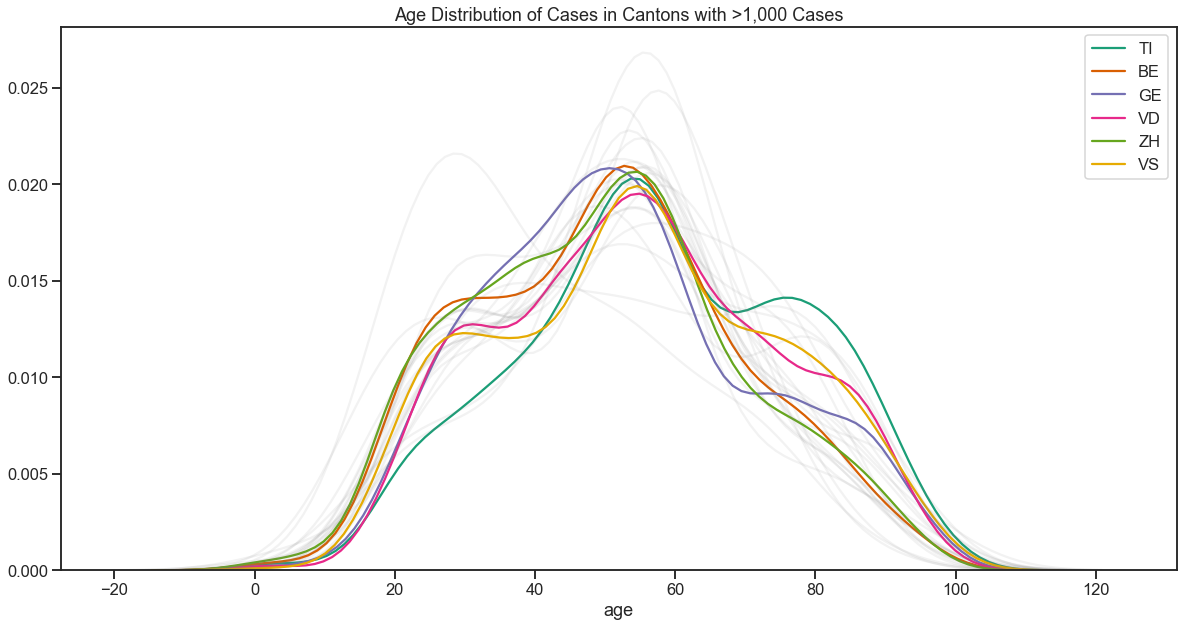

In [12]:
plt.figure(figsize=(20, 10))
sns.set_palette("Dark2")
for canton in df["Canton"].unique():
    if canton in ["BE", "GE", "ZH", "VD", "TI", "VS"]:
        sns.distplot(df[df["Canton"]==canton]["age"], label=canton, hist=False)
    else:
        sns.distplot(df[df["Canton"]==canton]["age"], hist=False, color="gray", kde_kws={"alpha": 0.1})

plt.title("Age Distribution of Cases in Cantons with >1,000 Cases")
plt.legend()

Interestingly, Ticino is still very distinct form the other cantons. There is again the missing bump between 20 and 30 years and an more pronounced one around 80. Let's now split between the sexes.

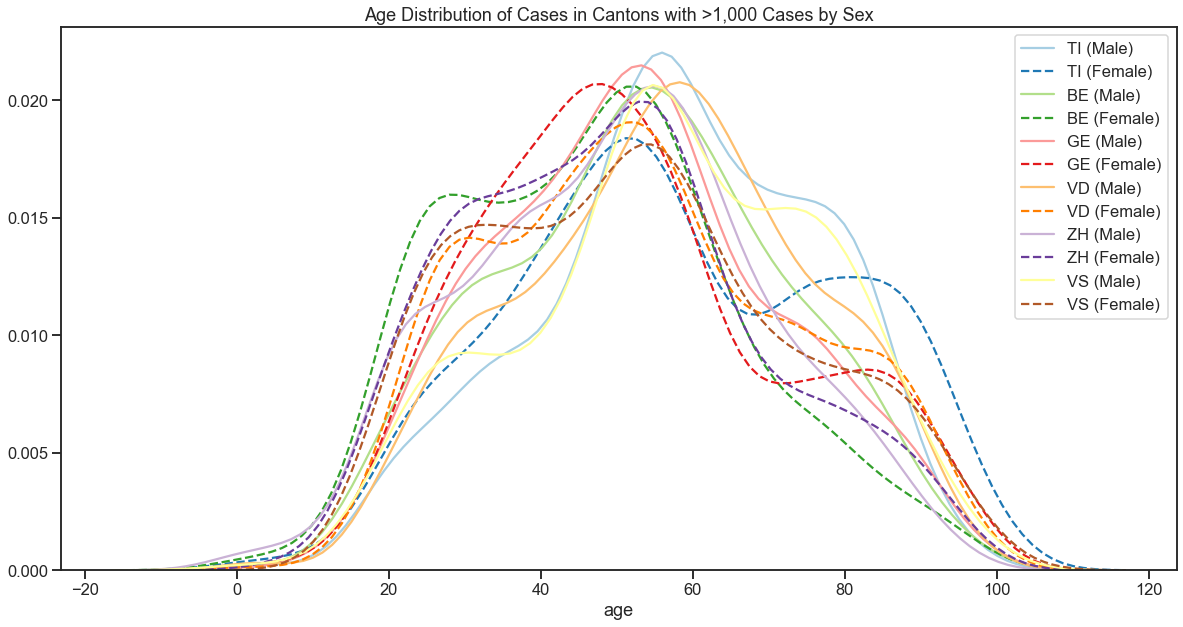

In [13]:
plt.figure(figsize=(20, 10))
sns.set_palette("Paired")
for canton in df["Canton"].unique():
    if canton in ["BE", "GE", "ZH", "VD", "TI", "VS"]:
        sns.distplot(df[(df["Canton"]==canton) & (df["sex"] == "Male")]["age"], label=canton + " (Male)", hist=False)
        sns.distplot(df[(df["Canton"]==canton) & (df["sex"] == "Female")]["age"], label=canton + " (Female)", hist=False, kde_kws={"linestyle": "--"})
        

plt.title("Age Distribution of Cases in Cantons with >1,000 Cases by Sex")
plt.legend()

Much of the same, not really interesting stuff. What about the Röschtigrabe?

Text(0.5, 1.0, 'Age Distribution in the Romandie (red) and the Deutschschweiz and Ticino (blue)')

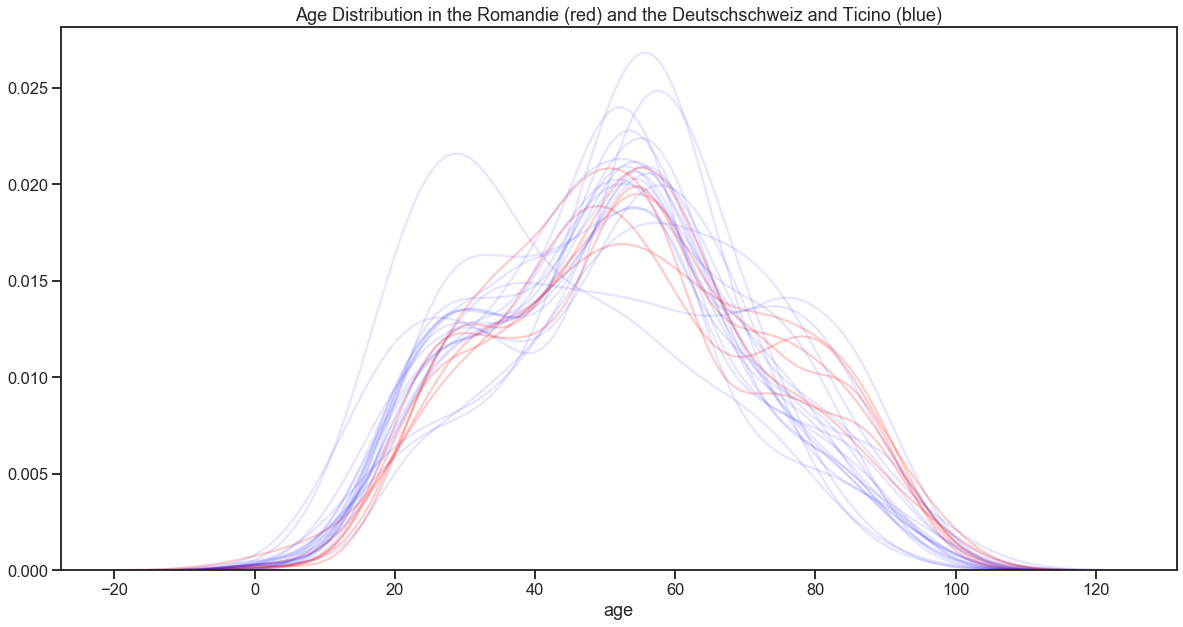

In [14]:
plt.figure(figsize=(20, 10))
for canton in df["Canton"].unique():
    if canton in ["GE", "VD", "VS", "FR", "NE", "JU"]:
        sns.distplot(df[df["Canton"]==canton]["age"], hist=False, kde_kws={"alpha": 0.2}, color="red")
    else:
        sns.distplot(df[df["Canton"]==canton]["age"], hist=False, kde_kws={"alpha": 0.1}, color="blue")

plt.title("Age Distribution in the Romandie (red) and the Deutschschweiz and Ticino (blue)")

Probably nothing interesting as well.

# Fatalities
Now let's have a look at how the fatalities distribute and compare to cases.

Text(0.5, 1.0, 'Outcome by Sex')

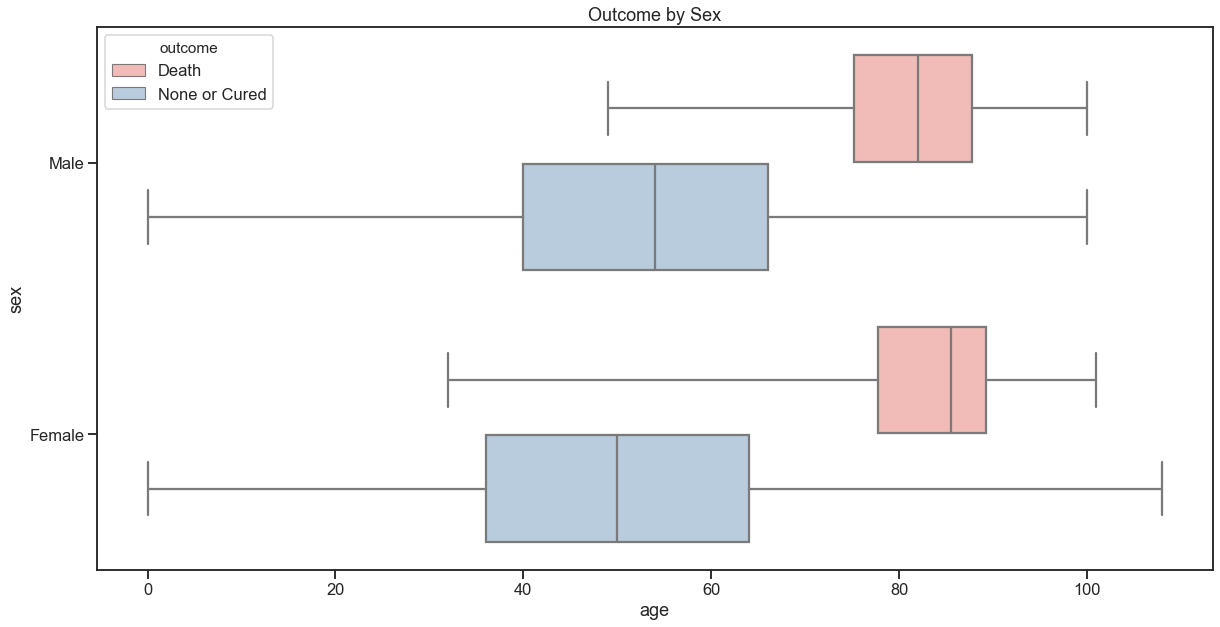

In [15]:
plt.figure(figsize=(20, 10))
sns.boxplot(x="age", y="sex", hue="outcome", data=df,
            whis="range", palette="Pastel1").set_title("Outcome by Sex")

From what is known about outcomes from other countries, the plot is not very surprising. What is interesting though is that the age in cases with the outcome death seems to be lower in men, while the overall age in men is higher.

Text(0.5, 1.0, 'Age Distribution of Fatalities')

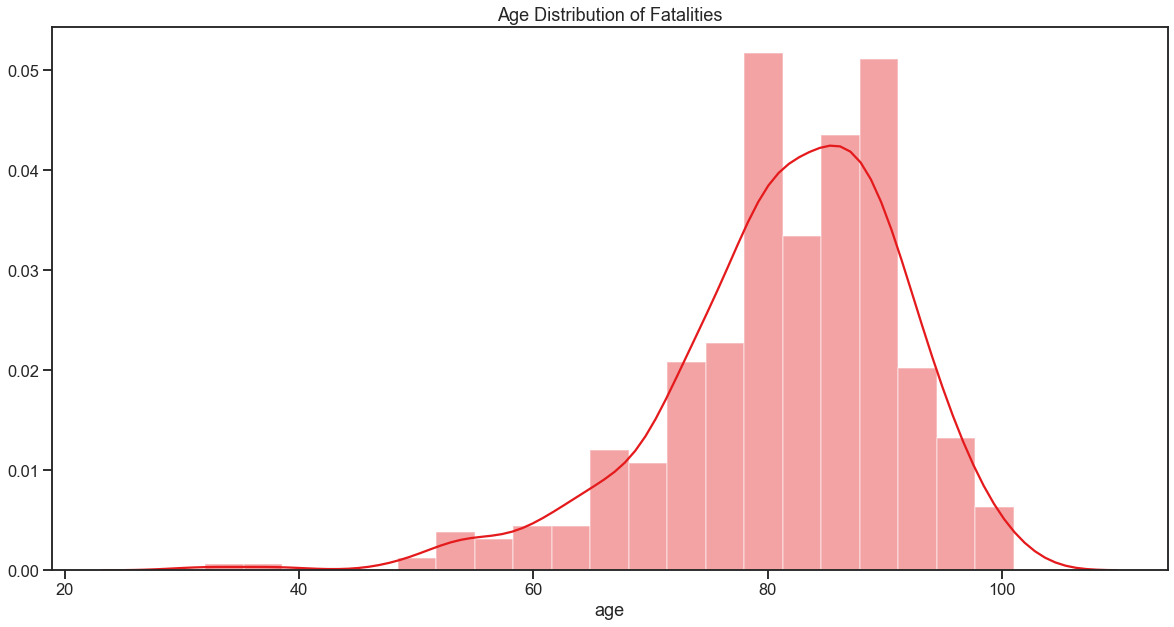

In [16]:
plt.figure(figsize=(20, 10))
sns.set_palette("Set1")
sns.distplot(df[df["outcome"]=="Death"]["age"]).set_title('Age Distribution of Fatalities')

And a look at the absolute numbers

In [17]:
df_tmp = pd.DataFrame(df[df["Anzahl Todesfälle"] == 1].groupby("age").sum()["Anzahl Todesfälle"]).T
tabulate.tabulate(df_tmp, headers=df_tmp.columns, tablefmt="html")

,32,38,49,50,53,54,55,57,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101
Anzahl Todesfälle,1,1,1,1,3,3,2,3,1,2,4,4,1,2,7,5,5,2,6,4,7,10,11,12,18,7,11,18,20,26,18,23,15,15,25,27,17,22,24,15,20,14,7,11,9,8,4,3,2,3,2


And the distribution by sex:

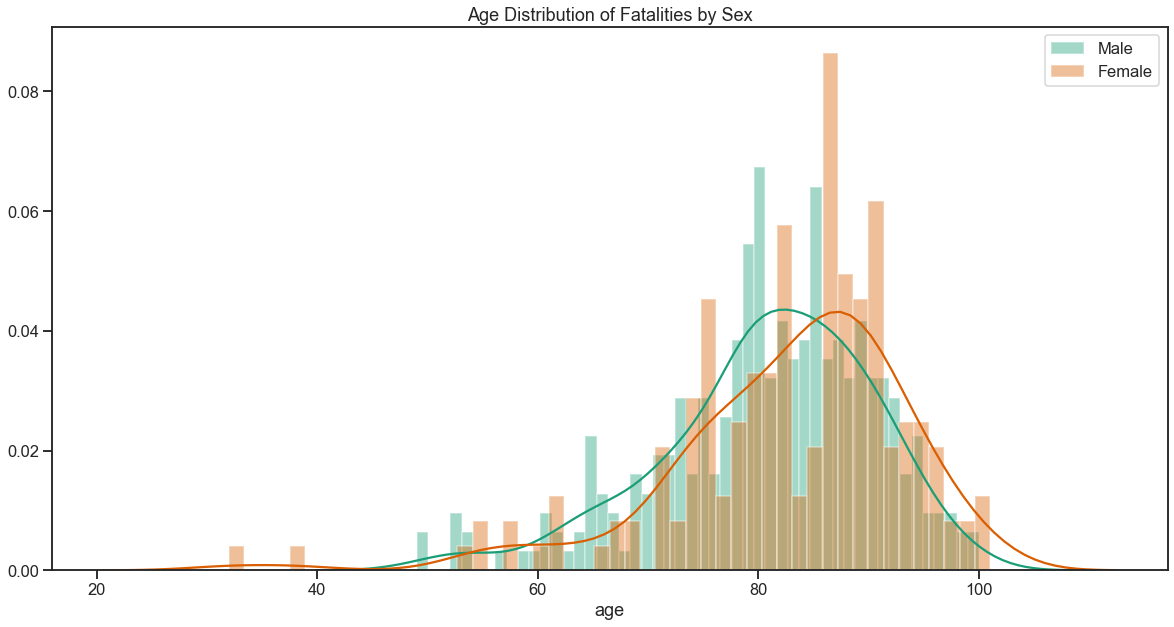

In [18]:
plt.figure(figsize=(20, 10))
sns.set_palette("Dark2")
sns.distplot(df[(df["outcome"]=="Death") & (df["sex"] == "Male")]["age"], label="Male", bins=50)
sns.distplot(df[(df["outcome"]=="Death") & (df["sex"] == "Female")]["age"], label="Female", bins=50).set_title('Age Distribution of Fatalities by Sex')
plt.legend()

The distribution of fatalities in females seems to be shifted to the right compared to males. There are some anomalies where there aren't many cases, however, as there isn't much data there is noise. Let's have a look at the cantons now.

Text(0.5, 1.0, 'Age by Canton (Fatal Outcome Only)')

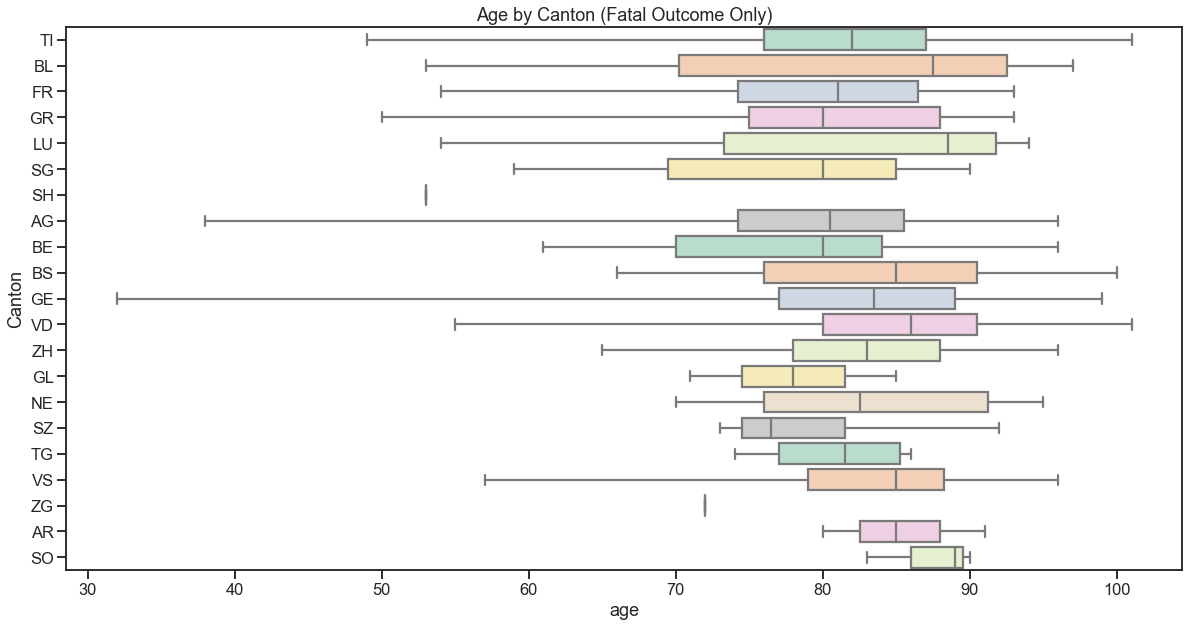

In [19]:
plt.figure(figsize=(20, 10))
sns.boxplot(x="age", y="Canton", data=df[df["outcome"]=="Death"],
            whis="range", palette="Pastel2")
plt.title("Age by Canton (Fatal Outcome Only)")

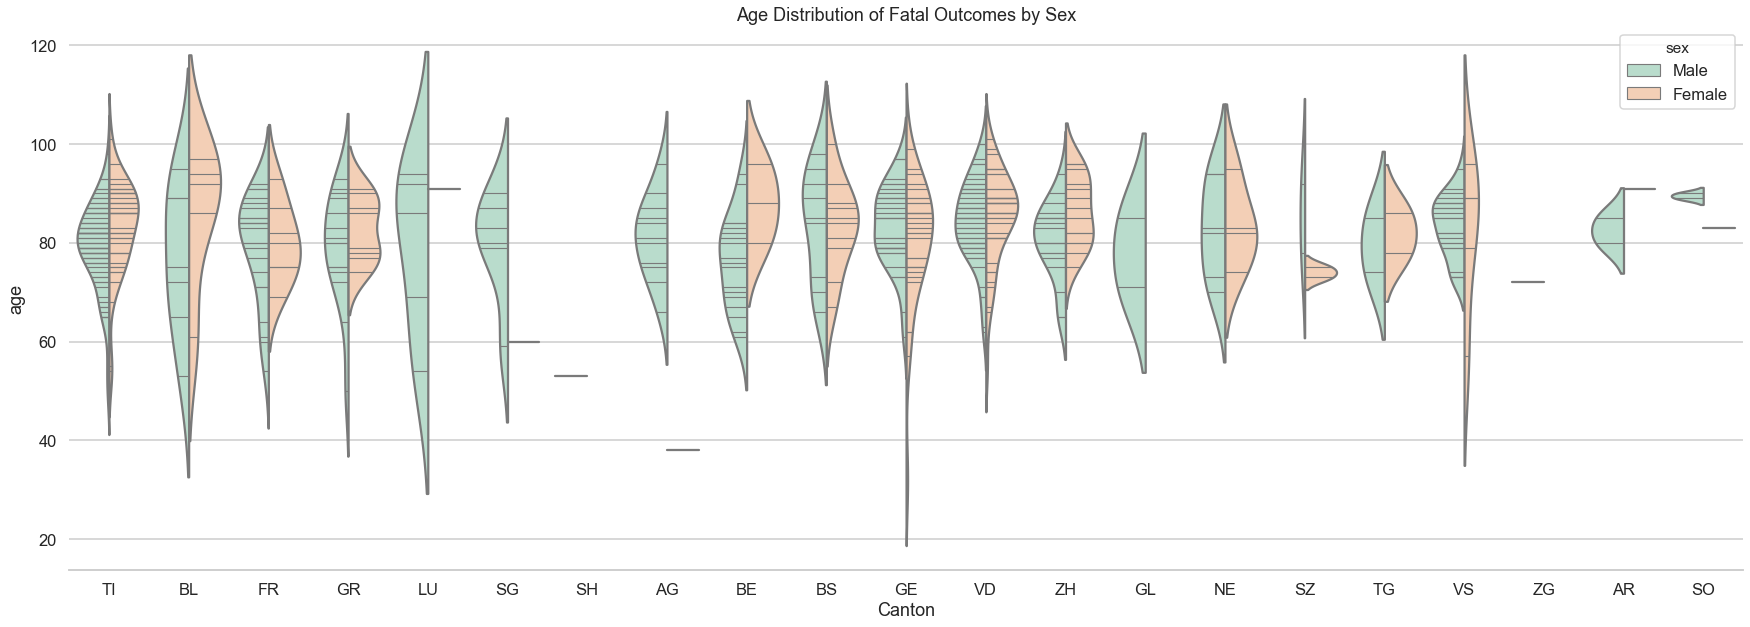

In [20]:
plt.figure(figsize=(30, 10))
sns.set(style="whitegrid", palette="Pastel2", context="talk")
sns.violinplot(x="Canton", y="age", hue="sex",
               split=True, inner="sticks",
               data=df[df["outcome"]=="Death"])

plt.title("Age Distribution of Fatal Outcomes by Sex")
sns.despine(left=True)

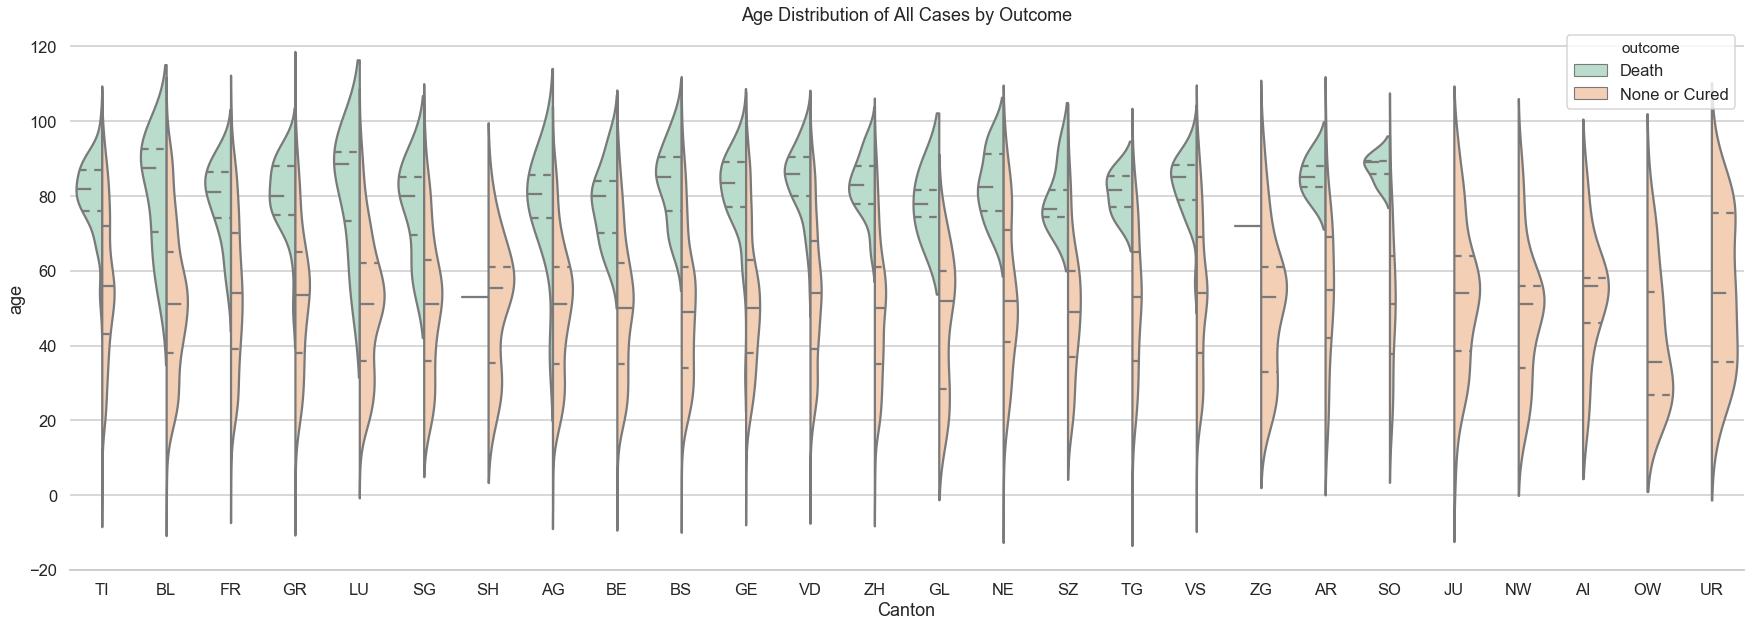

In [21]:
plt.figure(figsize=(30, 10))
sns.set(style="whitegrid", palette="Pastel2", context="talk")
sns.violinplot(x="Canton", y="age", hue="outcome",
               split=True, inner="quart",
               data=df)

plt.title("Age Distribution of All Cases by Outcome")
sns.despine(left=True)

Looks interesting, but with this little data, there really isn't too much to read into these distributions. Nevertheless, let's have a quick loock whether there are any significant differences. But first, the same data as a violin plot split by gender.

C:\Users\daenu\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\daenu\Miniconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\daenu\Miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\daenu\Miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\daenu\Miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


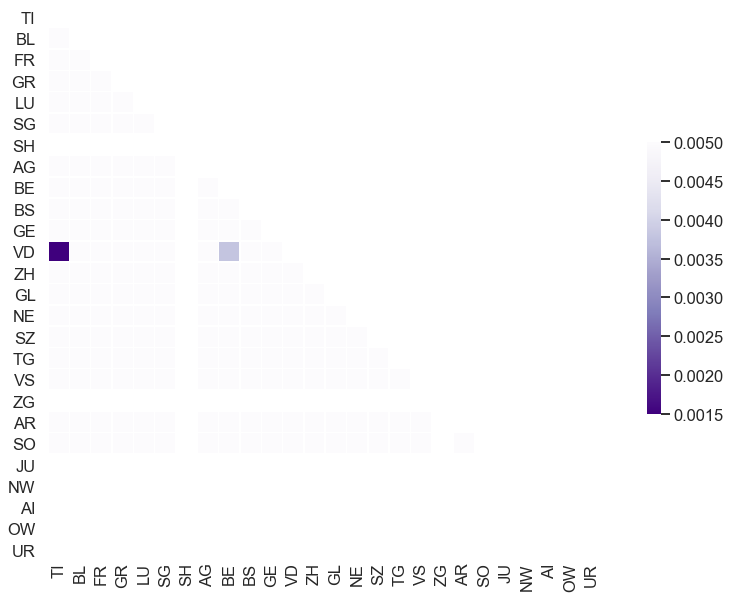

In [22]:
plt.figure(figsize=(20, 10))
cantons = df["Canton"].unique()
canton_age = {canton: df[(df["Canton"] == canton) & (df["outcome"] == "Death")]["age"].to_numpy() for canton in cantons if len(df[(df["Canton"] == canton) & (df["outcome"] == "Death")]) > 0}

t_stats = []

for i, a in enumerate(canton_age):
    t_stats.append([])
    for j, b in enumerate(canton_age):
        t = stats.ttest_ind(canton_age[a], canton_age[b])
        t_stats[i].append(math.sqrt(t.pvalue * t.pvalue))
#         print(a, b, t.pvalue)

sns.heatmap(t_stats, xticklabels=cantons, yticklabels=cantons, mask=np.triu(t_stats), vmax=0.005,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, cmap="Purples_r")

VD vs TI and BE look interesting, let's have a quick look at how the distributions compare.

C:\Users\daenu\Miniconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


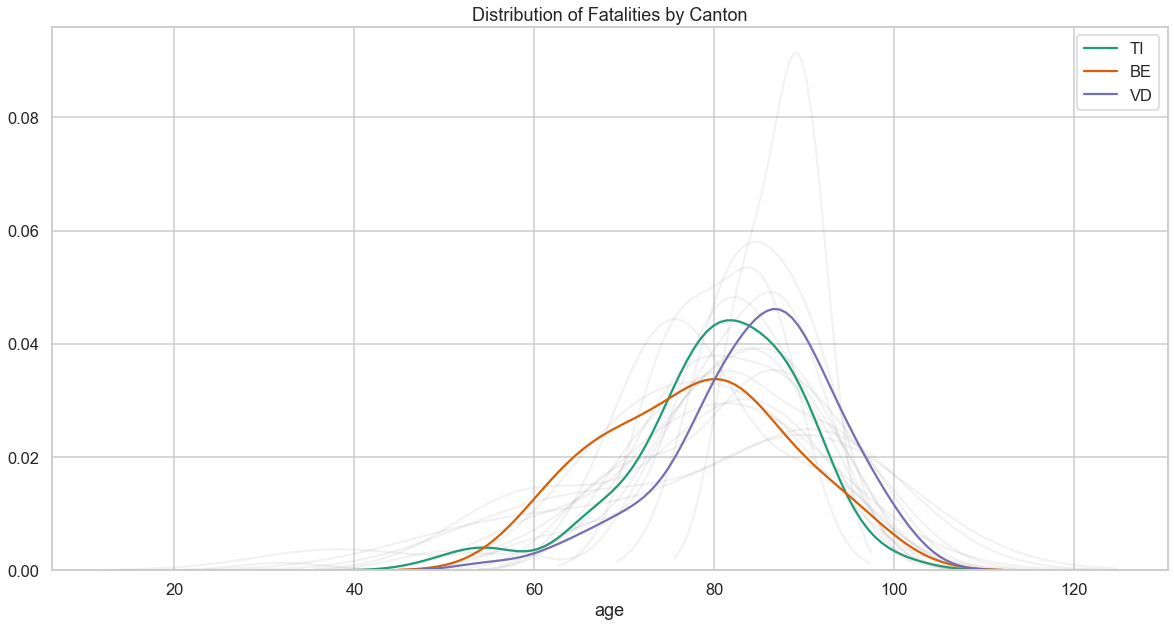

In [23]:
plt.figure(figsize=(20, 10))
sns.set_palette("Dark2")
for canton in df["Canton"].unique():
    if canton in ["TI", "VD", "BE"]:
        sns.distplot(df[(df["Canton"] == canton) & (df["outcome"] == "Death")]["age"], label=canton, hist=False)
    else:
        sns.distplot(df[(df["Canton"] == canton) & (df["outcome"] == "Death")]["age"], hist=False, color="gray", kde_kws={"alpha": 0.1})
plt.title("Distribution of Fatalities by Canton")
plt.legend()

Interestingly, in Bern, death seems to be the outcome in younger patients compared to Vaud and Ticino. Let's split this up by sex.

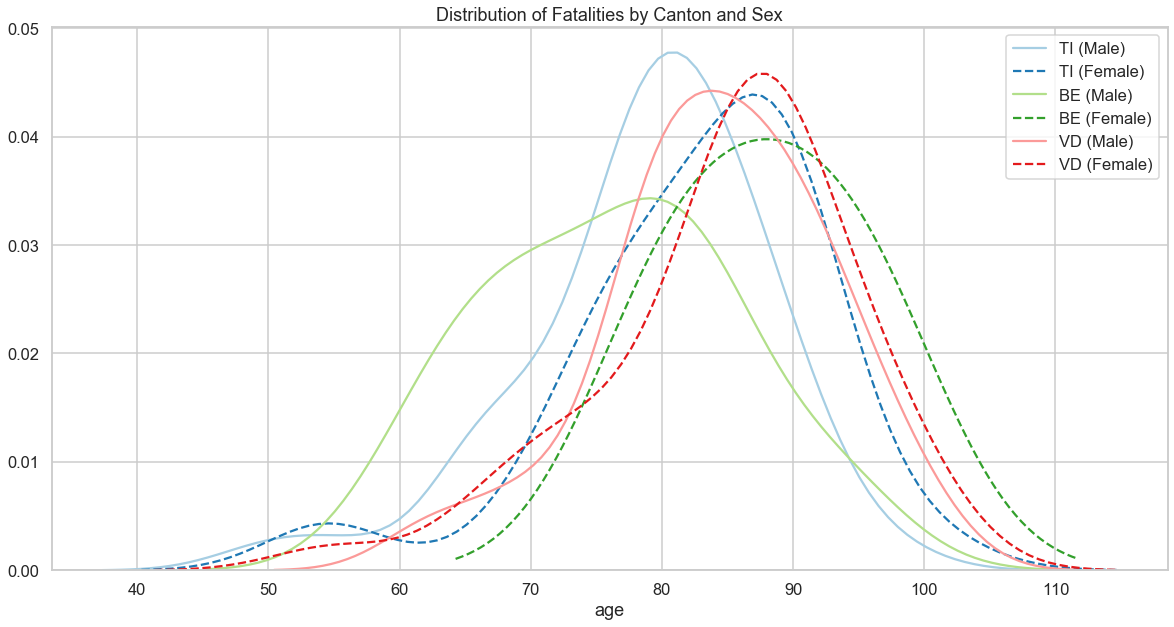

In [24]:
plt.figure(figsize=(20, 10))
sns.set_palette("Paired")
for canton in df["Canton"].unique():
    if canton in ["TI", "VD", "BE"]:
        sns.distplot(df[(df["Canton"]==canton) & (df["sex"] == "Male") & (df["outcome"] == "Death")]["age"], label=canton + " (Male)", hist=False)
        sns.distplot(df[(df["Canton"]==canton) & (df["sex"] == "Female") & (df["outcome"] == "Death")]["age"], label=canton + " (Female)", hist=False, kde_kws={"linestyle": "--"})
        
plt.title("Distribution of Fatalities by Canton and Sex")
plt.legend()

Interesting. It looks like this bump in younger deaths in Bern is caused by males. Let's have a look at the absolute numbers for Bern.

In [25]:
plt.figure(figsize=(20, 10))
df_tmp = pd.DataFrame(df[(df["Anzahl Todesfälle"] == 1) & (df["Canton"] == "BE")].groupby("age").sum()["Anzahl Todesfälle"]).T
tabulate.tabulate(df_tmp, headers=df_tmp.columns, tablefmt="html")

,61,62,65,67,69,70,71,75,76,77,80,81,82,83,84,88,92,94,96
Anzahl Todesfälle,1,1,1,1,1,1,1,1,1,1,2,1,1,1,2,1,1,1,1


<Figure size 1440x720 with 0 Axes>

So again, with this little data, it is very hard to reach any conclusion. In fact, one shouldn't.

# Case Fatality Ratios
Now to the CFRs (Cases Fatality Ratios)

sex
Female    0.017996
Male      0.034475
Name: cfr, dtype: float64


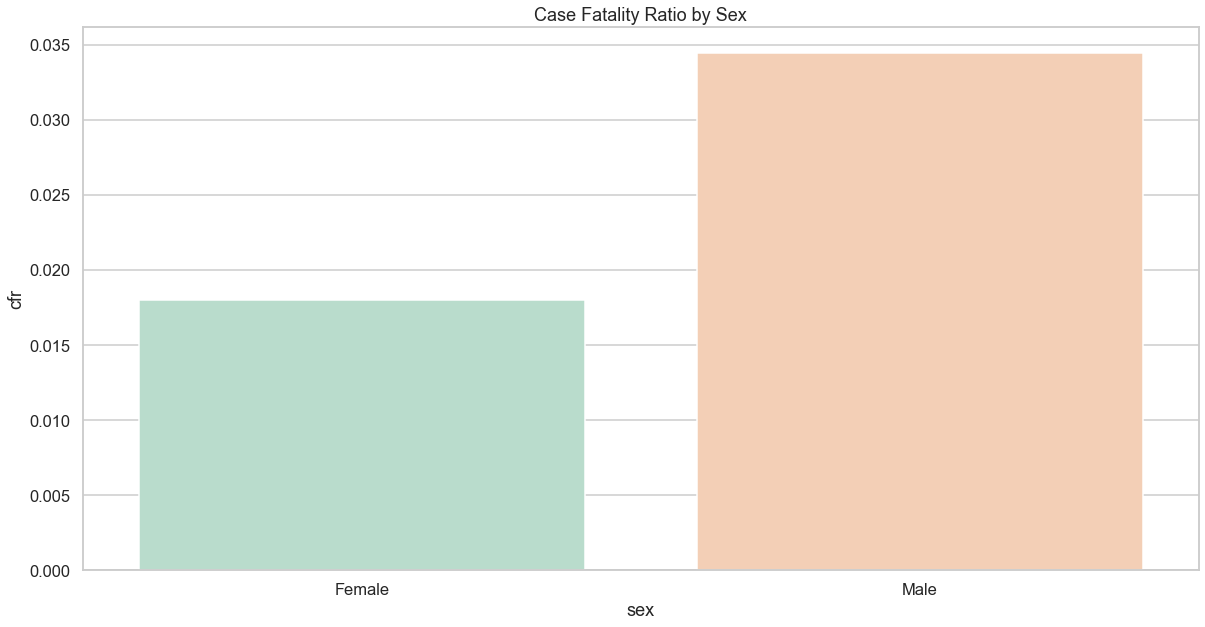

In [26]:
plt.figure(figsize=(20, 10))
df_tmp = df.groupby("sex").sum()
df_tmp["cfr"] = df_tmp["Anzahl Todesfälle"] / df_tmp["Number of Records"]
df_tmp['sex'] = df_tmp.index
g = sns.barplot(x="sex", y="cfr", data=df_tmp, palette="Pastel2")
plt.title("Case Fatality Ratio by Sex")
print(df_tmp["cfr"])

The case fatality ratio in males is cleary higher (about twice as high) compared to that in females. Does this hold true for all cantons? Let's first look at the overall CFRs per canton.

Text(0.5, 1.0, 'Case Fatality Ratio by Canton')

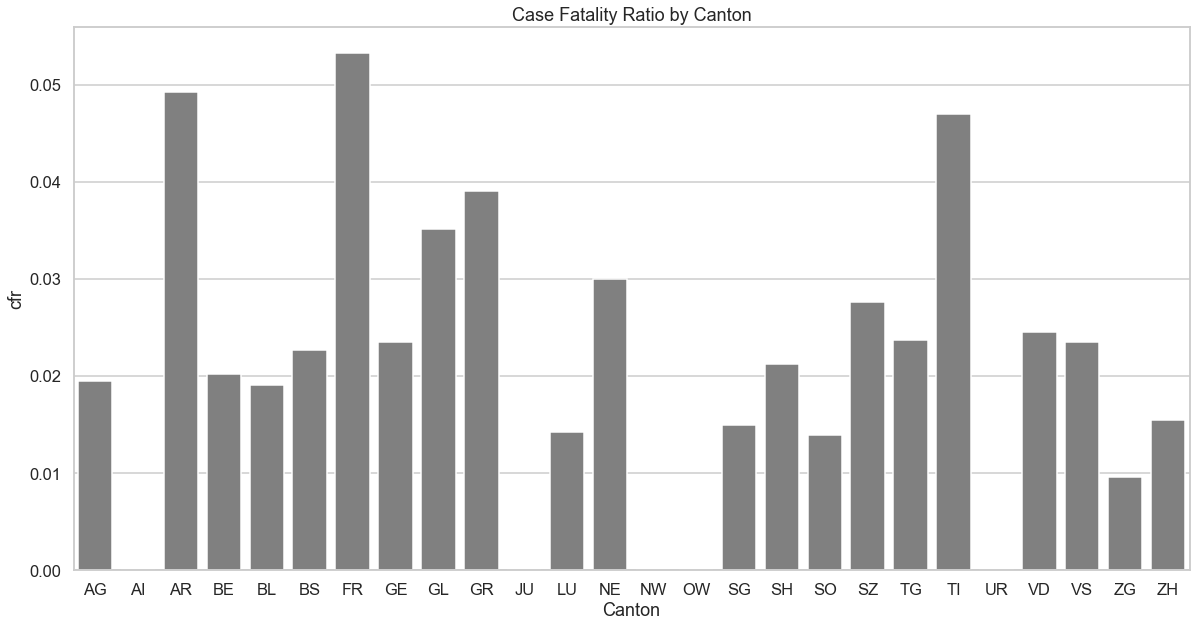

In [27]:
plt.figure(figsize=(20, 10))
df_tmp = df.groupby("Canton").sum()
df_tmp["cfr"] = df_tmp["Anzahl Todesfälle"] / df_tmp["Number of Records"]
df_tmp['Canton'] = df_tmp.index
g = sns.barplot(x="Canton", y="cfr", data=df_tmp, facecolor="gray")
plt.title("Case Fatality Ratio by Canton")

Split by sex, the pattern (higher CFR in males) repeats in most cantons.

Text(0.5, 1.0, 'Case Fatality Ratio by Canton and Sex')

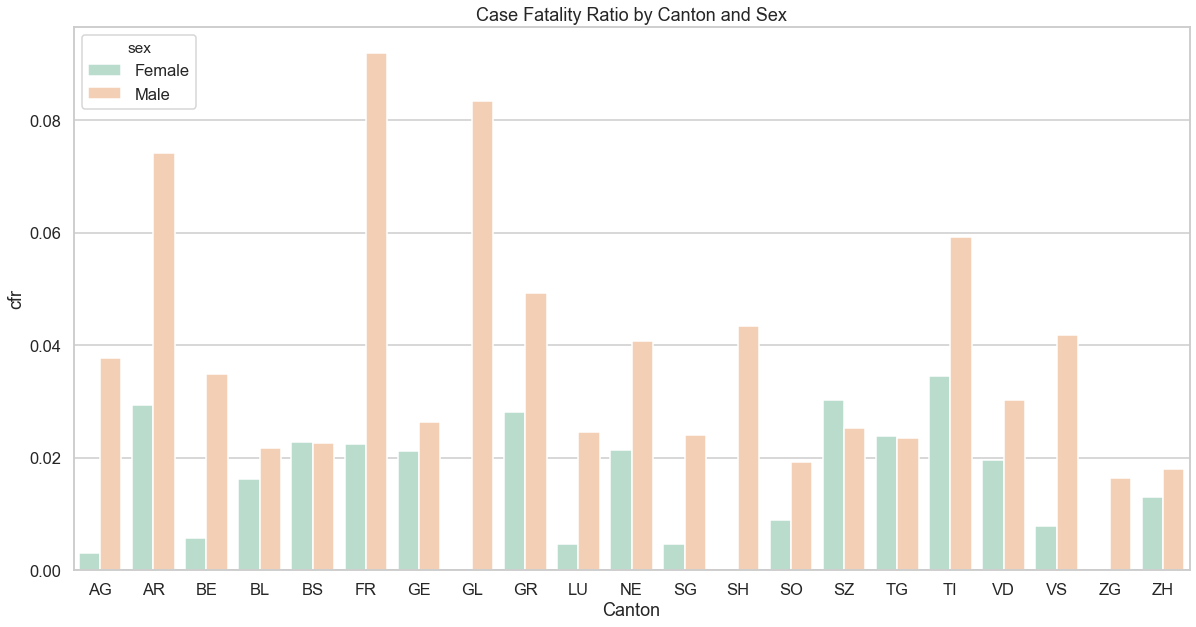

In [28]:
plt.figure(figsize=(20, 10))
sns.set_palette("Pastel2")
df_tmp = df.groupby(["Canton", "sex"]).sum().reset_index()  
df_tmp["cfr"] = df_tmp["Anzahl Todesfälle"] / df_tmp["Number of Records"]
df_tmp = df_tmp[df_tmp["cfr"] > 0]
g = sns.barplot(x="Canton", y="cfr", hue="sex", data=df_tmp)
plt.title("Case Fatality Ratio by Canton and Sex")

Text(0.5, 1.0, 'Case Fatality Ratio by Ag and Sex')

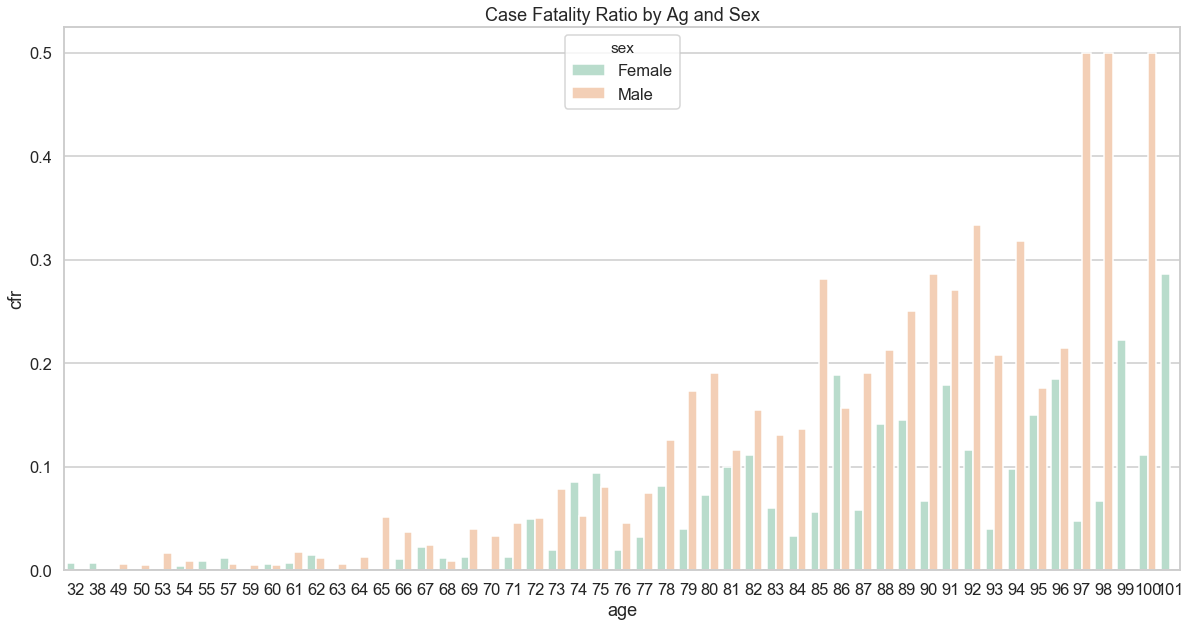

In [29]:
plt.figure(figsize=(20, 10))
sns.set_palette("Pastel2")
df_tmp = df.groupby(["age", "sex"]).sum().reset_index()  
df_tmp["cfr"] = df_tmp["Anzahl Todesfälle"] / df_tmp["Number of Records"]
df_tmp = df_tmp[df_tmp["cfr"] > 0]
g = sns.barplot(x="age", y="cfr", hue="sex", data=df_tmp)
plt.title("Case Fatality Ratio by Ag and Sex")

This is, to be fair, pretty much useless due to the low nuber of cases and outcomes.